In [2]:
from scipy import fft
from scipy import stats
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib as mpl

from skimage import io
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

Celem zadania jest pokazanie jakości kompresji obrazu za pomocą algotytmu `PCA`. Dla porównania zobaczymy, jak radzi sobie z tym zadaniem algorytm używany w kompresji standardu `jpeg`. Wczytajmy meme:

In [3]:
meme = io.imread('meme.jpeg')
print(meme[0:2])

[[[7 7 7]
  [2 2 2]
  [0 0 0]
  ...
  [0 0 0]
  [2 2 2]
  [7 7 7]]

 [[3 3 3]
  [2 2 2]
  [1 1 1]
  ...
  [1 1 1]
  [2 2 2]
  [3 3 3]]]


In [4]:
meme.shape

(1080, 1080, 3)

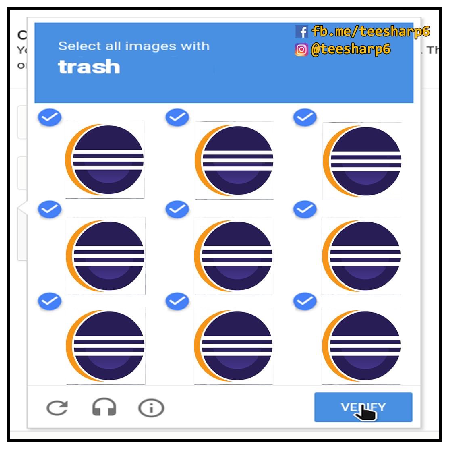

In [5]:
plt.figure(figsize=(8, 8))
plt.imshow(meme)
plt.axis('off')
plt.show()

Jak widzimy, jest śmieszne.

Opis algorytmów w telegraficznym skrócie:
### PCA
Tworzy kombincaje liniową kolumn obrazka tak, aby zostawić najbardziej się różniące.
### algorytm ze standardu `jpeg`
1. Obraz dzielony na bloki $8\times 8$
2. Szybka Transformata Cosinusowa (kuzyn Szybkiej Transformaty Fouriera) każdego takiego bloku
3. Wartości mniejsze od P (zwyczajowo 5% najwyższych wartości) są zerowane
4. Pozostałe ze zbioru wartości transformaty dzielone są na $64$ równej długości części
5. Każda z części kodowana jest ich średnią.

In [6]:
def pca_kompress(image, components):
    shape_org = image.shape
    
    image = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]))
    
    image_pca = PCA(n_components = components, svd_solver="randomized", random_state=0).fit(image)
    image_reduced = image_pca.transform(image)
    print("Wymiary po redukcji: ", image_reduced.shape)
    print("Procent redukcji: ", image_reduced.shape[0] * image_reduced.shape[1] / (image.shape[0] * image.shape[1]))
    print("Procent wyjaśnionej wariancji: ", np.sum(image_pca.explained_variance_ratio_))
    image_compressed = image_pca.inverse_transform(image_reduced)
    
    
    return np.reshape(image_compressed, shape_org)

Wymiary po redukcji:  (1080, 700)
Procent redukcji:  0.21604938271604937
Procent wyjaśnionej wariancji:  0.9999965429695812


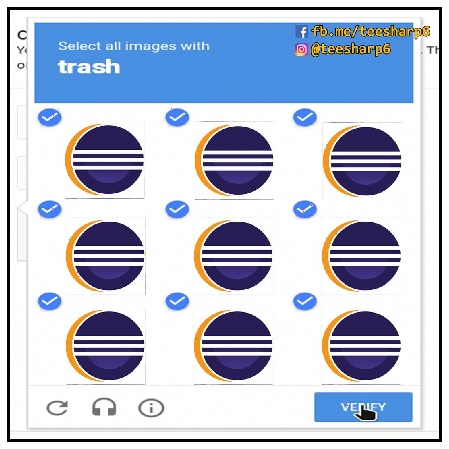

In [7]:
plt.figure(figsize=(8, 8))
plt.imshow(pca_kompress(meme,700).astype(np.uint8))
plt.axis('off')
plt.show()

In [8]:
def rozdziel(img):
    """
    Rozdziela obrazek kolorowy na 3 obrazki
    """
    return [img[:,:,0], img[:,:,1], img[:,:,2]]

In [9]:
def polacz(img):
    """
    Łączy podzielony na 3 obrazek w kolorowy
    """
    out = np.empty((img[0].shape + (3,)), dtype=np.uint8) # wymiaru takiego co dostałem, ale z 3 liczbami zamiast jednej
    
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            out[i,j] = np.array([img[0][i, j], img[1][i, j], img[2][i, j]])
    
    return out

In [10]:
def jpeg_kompress(image, P, M=64):
    image_3 = rozdziel(image)

    img_1 = jpeg_kompress_2d(image_3[0], P)
    print('25%')
    img_1[img_1 < 0] = 0
    img_1[img_1 > 255] = 255

    img_2 = jpeg_kompress_2d(image_3[1], P)
    print('50%')
    img_2[img_2 < 0] = 0
    img_2[img_2 > 255] = 255

    img_3 = jpeg_kompress_2d(image_3[2], P)
    print('75%')
    img_3[img_3 < 0] = 0
    img_3[img_3 > 255] = 255

    image_3_kompress = [img_1, img_2, img_3]

    image_kompress = polacz(image_3_kompress)
    print('100%')
    return image_kompress


def jpeg_kompress_2d(image, P, M=64):
    N = 8      # wymiar bloku NxN
    #P         # poziom odcięcia (1-P wszystkich częstotliwości zostanie zapisanych jako 0)
    #M         # liczba zbiorów wartości widma, w standardzie używa się 64, ale jego
                     # optymalność jest bardzo zależna od P - im mniejsze P,
                     # tym mniejsze może być M nie tracąc zbytnio na jakości kompresji

    shape_org = image.shape
    
    n_max = int(image.shape[0] / N)
    image_sub_dct = np.zeros(image.shape)
    image_compressed = np.zeros(image.shape)

    for n in range(0, n_max):
        for m in range(0, n_max):
            image_sub = image[(N * n):(N * (n + 1)), (N * m):(N * (m + 1))]
            image_sub_dct[(N * n):(N * (n + 1)), (N * m):(N * (m + 1))] = fft.dctn(image_sub)
            
    dct_ampl = np.sort(abs(image_sub_dct), axis=None)[::-1] # z tych bedziemy brali tylko P największych
    
    ndx = int(len(dct_ampl) * P)
    thresh = dct_ampl[ndx] # wartość graniczna, mniejsze będą równe 0

    num_min, num_max = image_sub_dct.min(), image_sub_dct.max()
    quant = np.linspace(num_max, thresh, M)
    d_quant = (quant[1] - quant[0]) / 2
    image_sub_dct_q = np.zeros(image.shape)
    for i in range(0, M - 1):   # tu jest uśrednianie niezerowych na M wartości
        image_sub_dct_q[(abs(image_sub_dct) <= quant[i]) * (abs(image_sub_dct) > quant[i + 1])] = quant[i] - d_quant
    image_sub_dct_q[(abs(image_sub_dct) <= quant[M - 1])] = 0  # tu jest zerowanie (1-P) najmniejszych
    image_sub_dct_q = image_sub_dct_q * np.sign(image_sub_dct)

    for n in range(0, n_max):
        for m in range(0, n_max):
            image_sub = image_sub_dct_q[(N * n):(N * (n + 1)), (N * m):(N * (m + 1))]
            image_compressed[(N * n):(N * (n + 1)), (N * m):(N * (m + 1))] = fft.idctn(image_sub)
    
    return image_compressed

25%
50%
75%
100%


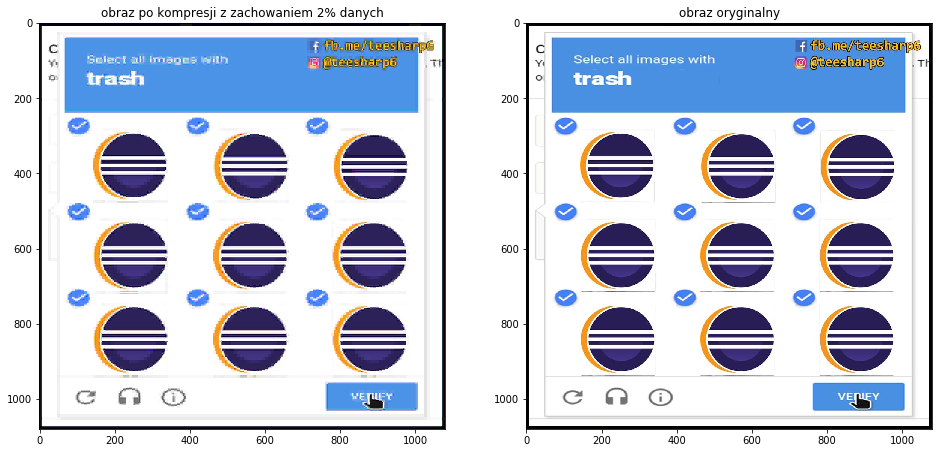

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12))
p = axes[0].imshow(jpeg_kompress(meme, 0.02, M=32))
axes[0].set_title("obraz po kompresji z zachowaniem 2% danych")
p = axes[1].imshow(meme)
axes[1].set_title("obraz oryginalny");

Tak wygląda kompresja z zachowaniem $2\%$ wartości. Na dodatek, wszystkie zapisane liczby są ze zbioru ${1, 2, 3, ..., 32}$ zamiast z ${0, 1, 2, ..., 255}$.

Kompresja jest więc ogromna, jednak obraz dalej czytelny i, co najważniejsze, śmieszny.

Porównajmy podobny poziom kompresji wykonany za pomocą PCA:

jpeg:
25%
50%
75%
100%
PCA:
Wymiary po redukcji:  (1080, 65)
Procent redukcji:  0.020061728395061727
Procent wyjaśnionej wariancji:  0.9893976501122568


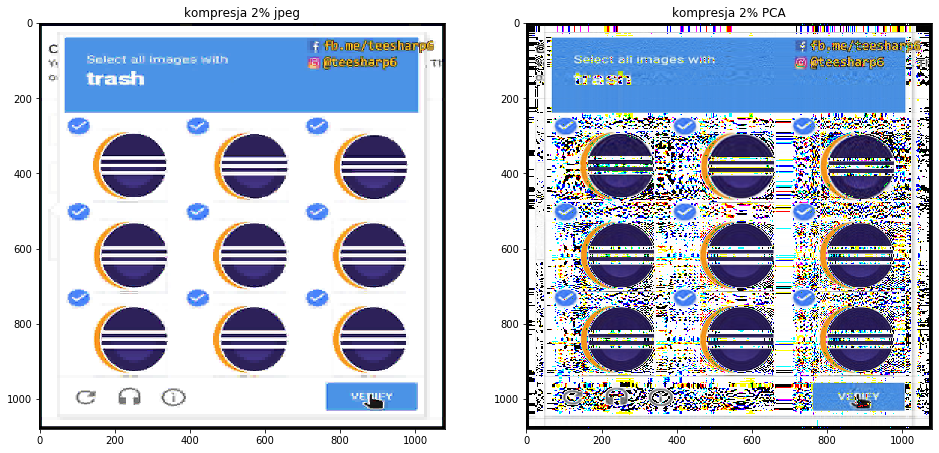

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12))
print("jpeg:")
p = axes[0].imshow(jpeg_kompress(meme, 0.02, M=32))
axes[0].set_title("kompresja 2% jpeg")
print("PCA:")
p = axes[1].imshow(pca_kompress(meme,65).astype(np.uint8))
axes[1].set_title("kompresja 2% PCA");

Jak więc widzimy kompresja za pomocą PCA jest absolutnie gorsza od algorytmu ze standardu `jpeg`. Można by nawet żec, że meme po dwu procentowej kompresji `PCA` nie jest już aż tak śmieszne, bo nie widać na pierwszy rzut oka, że jest to screen z `reCAPTCHA` w momencie, gdy to po lewej jest w pełni czytelne.

Sprawdźmy jakość kompresji z zachowaniem większych danych:

jpeg:
25%
50%
75%
100%
PCA:
Wymiary po redukcji:  (1080, 162)
Procent redukcji:  0.05
Procent wyjaśnionej wariancji:  0.9986208195690387


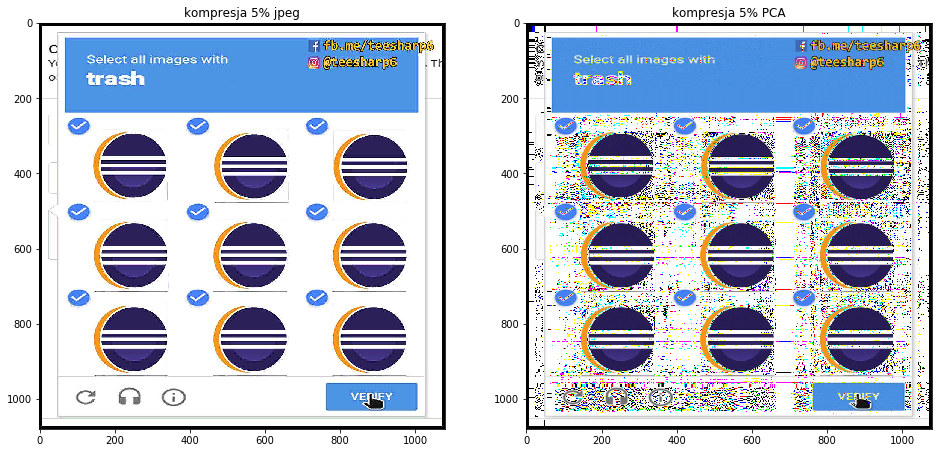

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12))
print("jpeg:")
p = axes[0].imshow(jpeg_kompress(meme, 0.05, M=64))
axes[0].set_title("kompresja 5% jpeg")
print("PCA:")
p = axes[1].imshow(pca_kompress(meme,162).astype(np.uint8))
axes[1].set_title("kompresja 5% PCA");

jpeg:
25%
50%
75%
100%
PCA:
Wymiary po redukcji:  (1080, 324)
Procent redukcji:  0.1
Procent wyjaśnionej wariancji:  0.9998512047444945


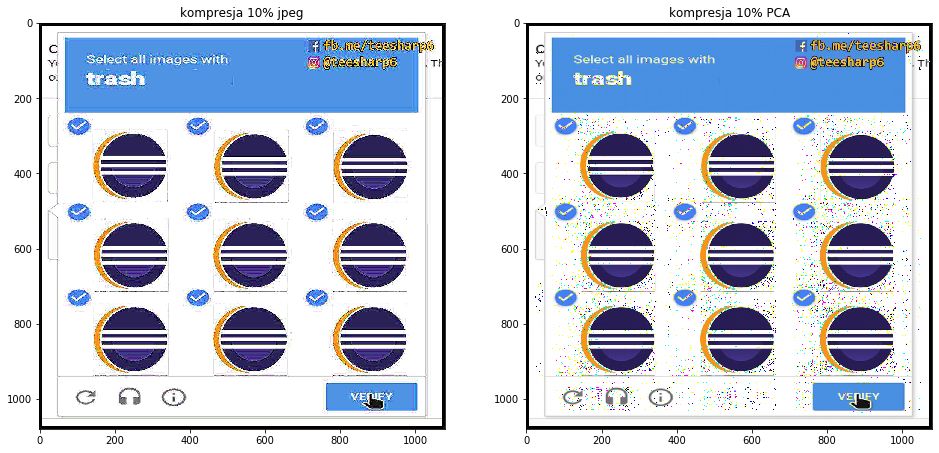

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12))
print("jpeg:")
p = axes[0].imshow(jpeg_kompress(meme, 0.1, M=64))
axes[0].set_title("kompresja 10% jpeg")
print("PCA:")
p = axes[1].imshow(pca_kompress(meme,324).astype(np.uint8))
axes[1].set_title("kompresja 10% PCA");

Dopiero na poziomie kompresji $10\%$ jakość algorytmu `PCA` jest porównywalna z jakością algorytmu wykorzystującego transformatę cosinusową, ale to i tak tylko dlatego, że ten z `jpeg` się "pogorszył", co dokładnie wyjaśnione jest poniżej.

### Jepiej zostawiać mało
Na koniec przykład na to, że w algorytmie używanym w `jpeg` wyjątkowo nie jest tak, że im więcej danych zachowany, tym jakość będzie lepsza.
Dla algorytmu tego zostawienie większej ilości danych dramatycznie wpływa negatywnie na jakość kompresji. Nic więc dziwnego, że powszechnie używa się go do dużej kompresji na obrazach.

25%
50%
75%
100%


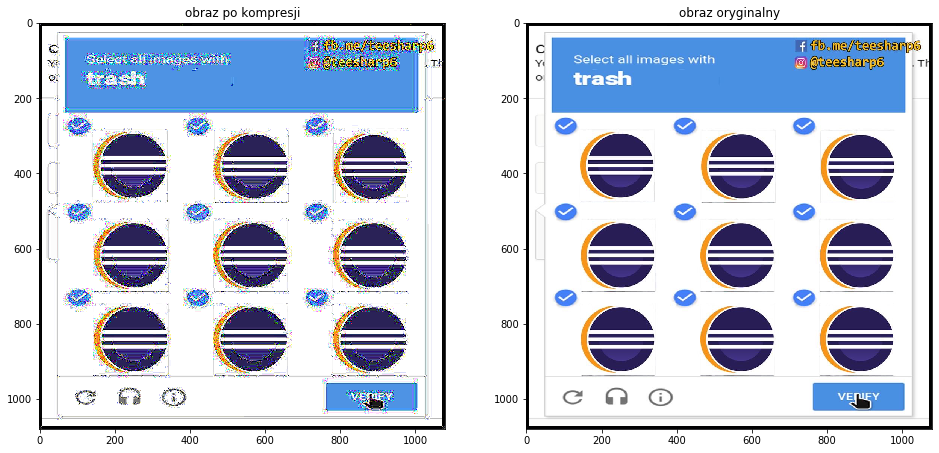

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12))
p = axes[0].imshow(jpeg_kompress(meme, P=0.2, M=64))
axes[0].set_title("obraz po kompresji")
p = axes[1].imshow(meme)
axes[1].set_title("obraz oryginalny");

Podsumowując:

Być może, że "PCA znakomicie sprawdza się do kompresji obrazków", ale algorytmy oparte na Szybkiej Transformacie Fouriera, czy Szybkiej Transformacie Cosinusowej są od `PCA` zdecydowanie leprze.

Potwierdzam samodzielność powyższej pracy oraz niekorzystanie przeze mnie z niedozwolonych źródeł.

Przemysław Chojecki